## Get size class distribution

This script imports aggregated output and then displays size class distribution for a subset of ensemble members.

The subset can be determined from the aggreagated data.

In [2]:
import pandas as pd
import glob
import os
import netCDF4 as nc4
import sys
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools')
from fields import fields
from constants import pft_colors
import esm_tools
from esm_tools import m2_per_ha
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
np.set_printoptions(threshold=1000)
import seaborn as sns
import importlib
importlib.reload(esm_tools)
import string
from matplotlib.lines import Line2D

## Functions

In [3]:
def rebin(df,rebin_suffix):
    df = df.copy()
    bins = [5, 20, 40, 60, 80, 100, 120, float('inf')]
    labels = ['10-20', '20-40', '40-60', '60-80', '80-100', '100-120', '>120']
    labels = [l + " " + rebin_suffix for l in labels]
    # Create a new column for binned size classes
    df['size_class'] = pd.cut(df['fates_levscls'], bins=bins, labels=labels, right=False, include_lowest=True)
    df = df.groupby(['harmonized_tag','pft_name','size_class']).sum()['n_per_ha'].reset_index()
    return df

def get_size_class_distribution_data(case_name,years,tag_numbers,tag_map,
                                     rebin_suffix = "",no_labels = False,
                                     metric = "density", plot = False,by_pft = True, dbh_min = 10,
                                     model_output_root = '/glade/derecho/scratch/adamhb'):
    pft_map = {1:"pine",2:"cedar",3:"fir",4:'shrub',5:'oak'}
    
    inst_tags = esm_tools.inst_to_tag(tag_numbers)
    output = pd.DataFrame()

    for i,tag_number in enumerate(tag_numbers):
        ds = esm_tools.load_fates_output_data(model_output_root=model_output_root,
                                              case_name = case_name,
                                              years = years,
                                              fields = fields,
                                              inst_tag = inst_tags[i],
                                              manual_path = None)

        if metric == "ba":
            fates_var = 'FATES_BASALAREA_SZPF'
        if metric == "density":
            fates_var = 'FATES_NPLANT_SZPF'

        # xarr = esm_tools.scpf_to_scls_by_pft(ds[fates_var], ds).mean(dim = "time").\
        #                  sel(fates_levpft = slice(0,3)).sel(fates_levscls = slice(5,None))
        
        xarr = esm_tools.scpf_to_scls_by_pft(ds[fates_var], ds).mean(dim = "time").\
                          isel(fates_levpft = [0,1,2,4]).sel(fates_levscls = slice(dbh_min,None))
        
        if by_pft == False:
            xarr = xarr.sum(dim = 'fates_levpft')

        df = xarr.to_dataframe(name='density').reset_index()
        df['n_per_ha'] = df['density'] * m2_per_ha
        df['tag_number'] = tag_number

        if by_pft == True:
            df['pft_name'] = df['fates_levpft'].map(pft_map)
        df['harmonized_tag'] = df['tag_number'].map(tag_map)
        df = rebin(df,rebin_suffix = rebin_suffix)
        
        output = pd.concat([output,df],axis = 0)

    return output

def plot_size_class_dist(df, title, row, x_axis_title, desired_pft_order=['pine', 'cedar', 'fir', 'oak'], remove_legend = False, log = False):
    ensemble_member_names = ['M1','M2','M3','M4','M5']
    figBaseName = title.replace(" ","").replace("(", "").replace(")", "")
    cz2_obs = [205.0, 136.0, 60.0, 13.0, 2.0, 0.0, 0.0]
    plt.rc('font', size=55)
    subplot_labels = list(string.ascii_lowercase)
    len_subplot_labels = len(subplot_labels)
    pft_colors = {'pine':'gold','cedar':'sandybrown','fir':'forestgreen','oak':'brown'}
    df = df.copy()
    sns.set(style="whitegrid")  # Optional: for better aesthetics

    # Ensure the colors are in the correct order
    colors = [pft_colors[pft] for pft in desired_pft_order]

    # Pivot the data
    df_pivot = df.pivot_table(index=['harmonized_tag', 'size_class'], columns='pft_name', values='n_per_ha', aggfunc='sum', fill_value=0)
    df_pivot = df_pivot.reset_index()

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(df['harmonized_tag'].unique()), figsize=(11, 3.7), sharey='row', sharex = True)

    tag_numbers = df['harmonized_tag'].unique()

    for i, tag in enumerate(tag_numbers):
        ax = axes[i]
        df_subset = df_pivot[df_pivot['harmonized_tag'] == tag]
        bars = df_subset.set_index('size_class')[desired_pft_order].plot(kind='bar', stacked=True, ax=ax, legend=(i == 0), color=colors)
        ax.set_title(ensemble_member_names[i])
        ax.set_xlabel(x_axis_title)
        ax.set_ylabel('Stem density [ha-1]' if i == 0 else '')
        #ax.set_ylim(0,207)
        if ((row * 5) + i) < len_subplot_labels:
           ax.text(-0.16, 1.1, subplot_labels[(row * 5) + i], transform=ax.transAxes, fontweight='bold', va='top')
        if log == True:
            ax.set_yscale('log')
        if title == '2015 (pre-treatment)':
            
            for c,container in enumerate(bars.containers):
                for b,bar in enumerate(container):
                    x_position = bar.get_x() + bar.get_width() / 2
                    y_position = cz2_obs[b]
                    ax.scatter(x_position, y_position, color='black',zorder = 5, marker = "*")
                    
                

        if i == 0:
            ax.legend(title='PFT')

        if (i == 1) & (title == '2015 (pre-treatment)'):
            star_legend = Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Obs')
            ax.legend(handles=[star_legend], loc='upper right')

        if remove_legend == True:
            legend = ax.legend()
            if legend:
                 legend.set_visible(False)
        
        # Add dark border to each bar
        for container in bars.containers:
            for bar in container:
                bar.set_edgecolor('black')
                bar.set_linewidth(1.5)

    fig.suptitle(title,y = 1.0)
    plt.tight_layout()
    figName = os.path.join(figOut,figBaseName + '.eps')
    #print(figName)
    plt.savefig(figName,format = 'eps')
    plt.show()

## Set up

In [4]:
figOut = '/glade/u/home/adamhb/california-fates/figures/'

peas_tag_map = {42:1,61:2,66:3,74:4,76:5}
f1870_to_2015_tag_map = {41:1,60:2,65:3,73:4,75:5}
SSP3_TREATED_tag_map = f1870_to_2015_tag_map
SSP3_no_treat_tag_map = {41:1,60:2,64:3,72:4,74:5}

case_info = {'1869 (pre-logging)':{'case_name':'equilibrium_700yrs_050924_01_-17e2acb6a_FATES-1449c787','years':[1869,1869],'tags':[42,61,66,74,76],'map':peas_tag_map},
              '1870 (post-logging)':{'case_name':'supIg_1.25_051424-1870-1951_-17e2acb6a_FATES-1449c787','years':[1870,1870],'tags':[41,60,65,73,75],'map':f1870_to_2015_tag_map},
              '2015 (pre-treatment)':{'case_name':'supIg_1.25_051424-1951-2020_-17e2acb6a_FATES-1449c787','years':[2014,2014],'tags':[41,60,65,73,75],'map':f1870_to_2015_tag_map},
              '2015 (post-treatment)':{'case_name':'supIg_1.25_051424-2015-2098-TREATED_-17e2acb6a_FATES-1449c787','years':[2015,2015],'tags':[41,60,65,73,75],'map':f1870_to_2015_tag_map},
              '2098 (no treatment)':{'case_name':'supIg_1.25_051424_wo0061-2015-2098_-17e2acb6a_FATES-1449c787','years':[2098,2098],'tags':[41,60,64,72,74],'map':SSP3_no_treat_tag_map},
              '2098 (single treatment)':{'case_name':'supIg_1.25_051424-2015-2098-TREATED_-17e2acb6a_FATES-1449c787','years':[2098,2098],'tags':[41,60,65,73,75],'map':f1870_to_2015_tag_map},
              '2098 (continuous treatment)':{'case_name':'supIg_1.25_052124_continuous-2015-2098-TREATED_-17e2acb6a_FATES-1449c787','years':[2098,2098],'tags':[41,60,64,72,74],'map':SSP3_no_treat_tag_map}}

## Cases that we need for the analysis

In [5]:
for i in case_info.keys():
    print(case_info[i]['case_name'])

equilibrium_700yrs_050924_01_-17e2acb6a_FATES-1449c787
supIg_1.25_051424-1870-1951_-17e2acb6a_FATES-1449c787
supIg_1.25_051424-1951-2020_-17e2acb6a_FATES-1449c787
supIg_1.25_051424-2015-2098-TREATED_-17e2acb6a_FATES-1449c787
supIg_1.25_051424_wo0061-2015-2098_-17e2acb6a_FATES-1449c787
supIg_1.25_051424-2015-2098-TREATED_-17e2acb6a_FATES-1449c787
supIg_1.25_052124_continuous-2015-2098-TREATED_-17e2acb6a_FATES-1449c787


## Load data

In [6]:
for case in case_info.keys():
    case_info[case]['data'] = get_size_class_distribution_data(case_name=case_info[case]['case_name'],
                                                               years = case_info[case]['years'],
                                                               tag_numbers=case_info[case]['tags'],
                                                               tag_map = case_info[case]['map'],
                                                               rebin_suffix="",no_labels=False,
                                                               metric = "density", by_pft=True, dbh_min=10)

-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have been read in -- 
-- your data have be

In [7]:
list(case_info.keys())

['1869 (pre-logging)',
 '1870 (post-logging)',
 '2015 (pre-treatment)',
 '2015 (post-treatment)',
 '2098 (no treatment)',
 '2098 (single treatment)',
 '2098 (continuous treatment)']

## Size class distribution figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


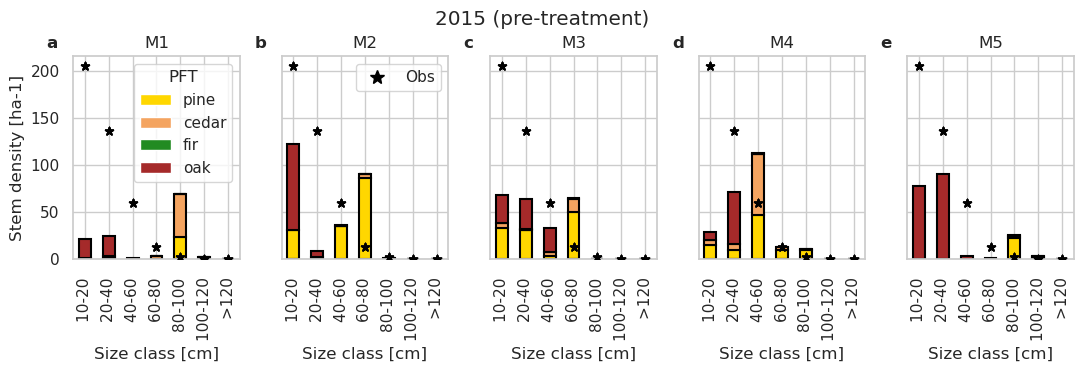

In [8]:
# time_periods = [
#  #'1869 (pre-logging)',
#  '2015 (pre-treatment)'
#  #'2098 (no treatment)',
#  #'2098 (single treatment)',
#  #'2098 (continuous treatment)']
plot_size_class_dist(case_info['2015 (pre-treatment)']['data'], row=0, title = '2015 (pre-treatment)', x_axis_title = "Size class [cm]", remove_legend=False)

## Fig for SI

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


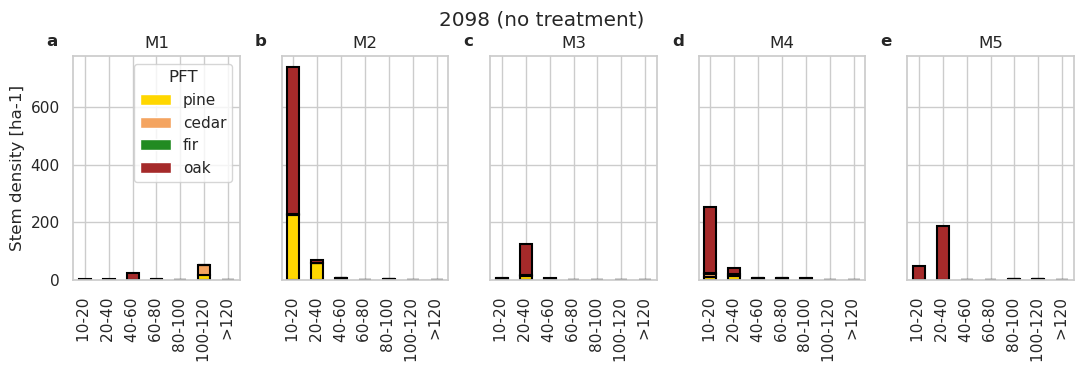

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


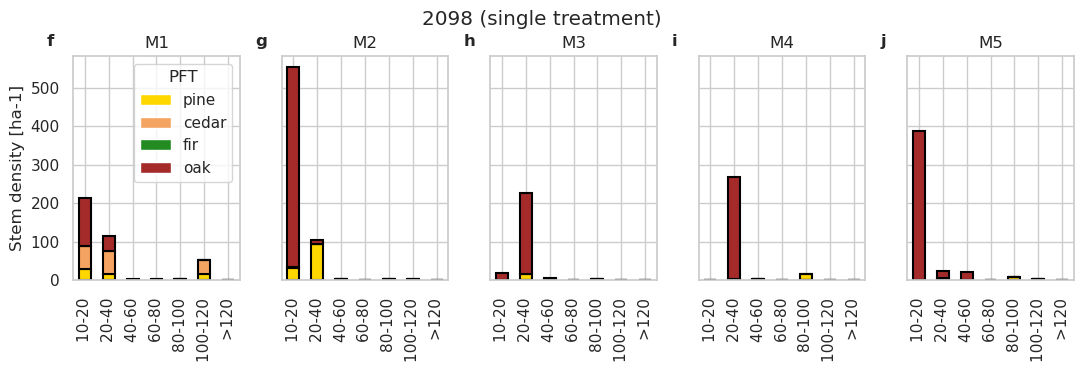

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


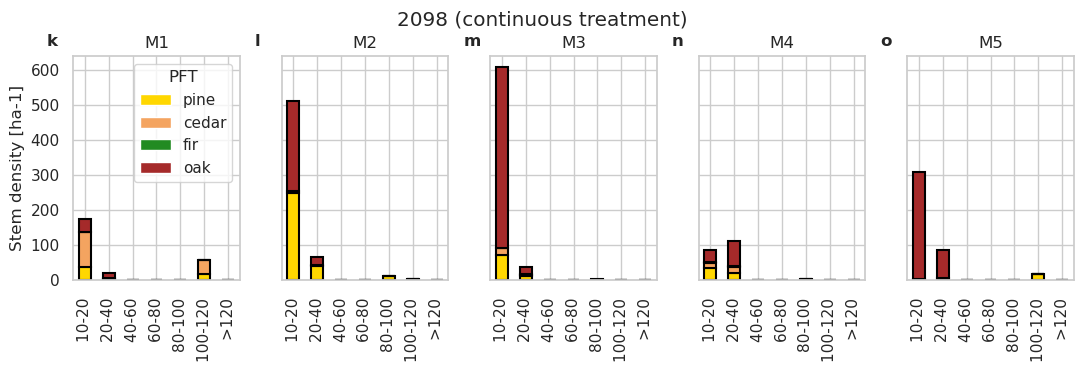

In [9]:
time_periods = [
 #'1869 (pre-logging)',
 #'2015 (pre-treatment)',
 '2098 (no treatment)',
 '2098 (single treatment)',
 '2098 (continuous treatment)']

row = -1
for case in time_periods:
    row = row + 1
    if row == len(case_info.keys()) - 1:
        x_axis_title = "Size class [cm]"
    else:
        x_axis_title = ""
    plot_size_class_dist(case_info[case]['data'], row=row, title = case, x_axis_title = x_axis_title, remove_legend=False)

### See Data

In [12]:
d = case_info['2015 (pre-treatment)']['data']
filter = d['pft_name'] == 'fir'
d[filter]

,harmonized_tag,pft_name,size_class,n_per_ha
7,1,fir,10-20,0.006181
8,1,fir,20-40,0.002135
9,1,fir,40-60,0.037572
10,1,fir,60-80,0.052152
11,1,fir,80-100,0.205185
12,1,fir,100-120,0.008042
13,1,fir,>120,0.000000
7,2,fir,10-20,0.000000
8,2,fir,20-40,0.130209
9,2,fir,40-60,0.024020


In [10]:
case_info['2098-continuous-treatment']['data']

KeyError: '2098-continuous-treatment'

In [ ]:
case_info['2098-no-treatment']['data']